# Process Variation Modelling
This notebook models processing variation induced variation for Resonance Wavelength(LAMDA_R), Quality Factor(Q), Extinction Ratio(ER), and FINESSE.

We generate both interdie and intradie process variation data. We also generate heatmap of dies in the presence of process variation.

The output folder structure generated by the script looks like below:
```bash
├───interpvfolder
│   ├───ER
│   │   └───Block1by1
│   ├───FINESSE
│   │   └───Block1by1
│   ├───LAMDA_R
│   │   └───Block1by1
│   └───Q
│       └───Block1by1
├───intrapvfolder
│   ├───ER
│   │   └───Block1by1
│   ├───FINESSE
│   │   └───Block1by1
│   ├───LAMDA_R
│   │   └───Block1by1
│   └───Q
│       └───Block1by1
└───pvfigures
    ├───ER
    │   └───Block1by1
    ├───FINESSE
    │   └───Block1by1
    ├───LAMDA_R
    │   └───Block1by1
    └───Q
        └───Block1by1

```
### We have used below articles to model process variations:

[1] R. Wu et al., "Variation-aware adaptive tuning for nanophotonic interconnects," 2015 IEEE/ACM International Conference on Computer-Aided Design (ICCAD), Austin, TX, USA, 2015, pp. 487-493, doi: 10.1109/ICCAD.2015.7372609.

[2] Y. Wang et al., "Energy-efficient channel alignment of DWDM silicon photonic transceivers," 2018 Design, Automation & Test in Europe Conference & Exhibition (DATE), Dresden, Germany, 2018, pp. 601-604, doi: 10.23919/DATE.2018.8342079.

[3] Yuyang Wang, M. Ashkan Seyedi, Jared Hulme, Marco Fiorentino, Raymond G. Beausoleil, and Kwang-Ting Cheng. 2019. Bidirectional tuning of microring-based silicon photonic transceivers for optimal energy efficiency. In Proceedings of the 24th Asia and South Pacific Design Automation Conference (ASPDAC '19). Association for Computing Machinery, New York, NY, USA, 370–375. https://doi.org/10.1145/3287624.3287649

[4] Y. Wang et al., "Characterization and Applications of Spatial Variation Models for Silicon Microring-Based Optical Transceivers," 2020 57th ACM/IEEE Design Automation Conference (DAC), San Francisco, CA, USA, 2020, pp. 1-6, doi: 10.1109/DAC18072.2020.9218608.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

parameters = ['LAMDA_R', 'Q', 'ER', 'FINESSE']
parmeters_mean = {'Q':6500,
                  'ER':10,
                  'LAMDA_R':1550}
parameters_std_intra = {'Q':(0.076144+0.094),#(intra std+ residual std)
                  'ER':(0.070406+0.0891),#(intra std+ residual std)
                  'LAMDA_R':0.17,#(Local variation std)
                        'FINESSE':(0.076144+0.094)}
parameters_std_inter = {'Q':0.06536,#(inter std)
                  'ER':0.06049,#(inter std)
                  'LAMDA_R':(0.33+1.40),#(Global +TXRX)
                        'FINESSE':0.06536}

Q_MEAN = parmeters_mean['Q']
FSR = 20 #nm
LAMDA_R = parmeters_mean['LAMDA_R']
parmeters_mean['FINESSE'] = (Q_MEAN*FSR)/LAMDA_R

die_xdim = 15 #mm
die_ydim = 30 #mm

# ring_radius = 5*1e-3 #mm
# pitch = 5*1e-3 #mm

# block_xdim = 2*(ring_radius)+2*(pitch)
# block_ydim = 2*(ring_radius)+2*(pitch)
block_xdim = 0.1#mm
block_ydim = 0.1 #mm
folder_name = 'Block1by1'


print(int(die_xdim/block_xdim))
print(int(die_ydim/block_ydim))
no_of_blocks = int(die_xdim/block_xdim)*int(die_ydim/block_ydim)

for parameter in parameters:
       print("Parameter",parameter)
       mean = parmeters_mean[parameter]
       std_intra = parameters_std_intra[parameter]
       xpos = [0]
       if parameter=='LAMDA_R':
              distribution = np.random.normal(mean, std_intra, int(no_of_blocks))

       else:
              distribution = np.random.normal(mean, mean*std_intra, int(no_of_blocks))
       waffer_map = distribution.reshape(int(die_ydim / block_ydim),int(die_xdim / block_xdim))
       print(waffer_map.shape)
       if not os.path.exists('intrapvfolder/'+parameter+'/'+folder_name):
              os.makedirs('intrapvfolder/'+parameter+'/'+folder_name)


       np.savetxt('intrapvfolder/'+parameter+'/'+folder_name+'IntraPV_'+parameter+'_block'+str(block_xdim*10)+'_'+str(block_ydim*10)+'.csv', waffer_map, delimiter=',')
       fig, ax = plt.subplots()
       waffer_map = np.ma.masked_where(waffer_map == 0, waffer_map)
       cmap = matplotlib.cm.YlOrRd
       cmap.set_bad(color='white')
       im = ax.imshow(waffer_map, cmap=cmap, aspect='auto', interpolation='none')
       # ax.set_xticks(np.arange(0, 240, 24));
       # ax.set_yticks(np.arange(0, 16, 1));
       ax.set_xlabel("Intra Die "+parameter)
       fig.colorbar(im, orientation='vertical')

       if(parameter=='FINESSE'):
              title = "Q={q}, FSR={fsr}nm, Finesse={finesse:.2f}, Lamda_R= 1550nm  ".format(
                     q=Q_MEAN, fsr=20,
                     finesse=parmeters_mean['FINESSE'])
              ax.set_title(title)
       else:
              ax.set_title('Block_Size ' + str(block_xdim) + 'mm' + ' X ' + str(block_ydim) + 'mm')
       plt.savefig('intrapvfolder/'+parameter+'/'+folder_name+'/IntraPV_'+parameter+'_block'+str(int(block_xdim*1000))+'_'+str(int(block_ydim*1000))+'.png',dpi=1000)

       # plt.show()

       no_of_dies = 80
       std_inter_die = parameters_std_inter[parameter]
       inter_die_map = []
       for die in range(no_of_dies):
              waffer_map_inter_die = []
              for block_value in range(no_of_blocks):
                     if parameter == 'LAMDA_R':
                            waffer_map_inter_die.append(
                                   np.random.normal(distribution[block_value],
                                                    std_inter_die, 1)[0])
                     else:
                            waffer_map_inter_die.append(
                                   np.random.normal(distribution[block_value], distribution[block_value] * std_inter_die, 1)[0])
              inter_die_map.append(waffer_map_inter_die)

       # creating csv's
       for die in range(no_of_dies):
              print("Die",die)
              map = np.array(inter_die_map[die]).reshape(int(die_ydim / block_ydim),int(die_xdim / block_xdim))
              # print("Inter Map :",map.shape)
              if not os.path.exists('interpvfolder/' + parameter + '/' + folder_name):
                     os.makedirs('interpvfolder/' + parameter + '/' + folder_name)

              np.savetxt('interpvfolder/'+parameter+'/'+folder_name+'/InterDie_' +parameter+'_'+ str(die) +'_block'+str(int(block_xdim*1000))+'_'+str(int(block_ydim*1000))+".csv", map, delimiter=',')
              fig, ax = plt.subplots()
              waffer_map = np.ma.masked_where(waffer_map == 0, waffer_map)
              cmap = matplotlib.cm.YlOrRd
              cmap.set_bad(color='white')
              im = ax.imshow(map, cmap=cmap, aspect='auto', interpolation='none')
              # ax.set_xticks(np.arange(0, 240, 24));
              # # ax.set_yticks(np.arange(0, 16, 1));
              ax.set_xlabel("Inter Die " + parameter)
              if (parameter == 'FINESSE'):
                     title = "Q={q}, FSR={fsr}nm, Finesse={finesse:.2f}, Lamda_R= 1550nm  ".format(
                            q=Q_MEAN, fsr=20,
                            finesse=parmeters_mean['FINESSE'])
                     ax.set_title(title)
              else:
                     ax.set_title('Block_Size ' + str(block_xdim) + 'mm' + ' X ' + str(block_ydim) + 'mm')
              # ax.set_title('Block_Size ' + str(block_xdim) + 'mm' + ' X ' + str(block_ydim) + 'mm')
              fig.colorbar(im, orientation='vertical')
              if not os.path.exists('pvfigures/' + parameter + '/' + folder_name):
                     os.makedirs('pvfigures/' + parameter + '/' + folder_name)

              plt.savefig('pvfigures/'+parameter+'/'+folder_name+'/InterDie_'+parameter+ str(die)+'_'+'_block'+str(int(block_xdim*1000))+'_'+str(int(block_ydim*1000))+'.png',dpi=1000)
              # plt.show()
              # print("Plot Inter")
              # print("Parameter",parameter)

       print("Finished Parameter", parameter)


# Generating Waffer Level Figure from Inter Process Variation data generated from previous step
Note: The below code cannot be used for LAMDA_R waffer map generation. Please use next section for LAMDA_R

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import os
from os import listdir
from os.path import isfile, join

die_data_path = "/content/interpvfolder/FINESSE/Block1by1"

# import glob
# print(glob.glob("/pvfigures/Q/*.png"))
#


search_dir = die_data_path
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files]  # add path to each file
print(files)

files.sort(key=lambda x: os.path.getmtime(x))
dt = pd.read_csv(files[0]).to_numpy()
no_of_row = 8
no_of_columns = 10
die_x_dim = dt.shape[0]
die_y_dim = dt.shape[1]
# print(dt.shape[0])
# print(dt.shape[1])
wafferarray = np.zeros((dt.shape[0] * no_of_row, dt.shape[1] * no_of_columns))
# print(wafferarray.shape)
no_of_dies = 80
die_number = 0
blockrowstartidx = 0
columnstartidx = 0
empty_rows = [0, 1, 6, 7]

empty_columns_for_row = {0: [0, 1, 7, 8, 9],
                         1: [0, 9],
                         6: [0, 9],
                         7: [0, 1, 7, 8, 9]}
parameter = 'Q'
for i in range(0, no_of_row):
    blockrowstartidx = i * die_x_dim
    print("blockrowstartidx  :", blockrowstartidx)
    for j in range(0, no_of_columns):
        print("Die :", die_number)
        columnstartidx = j * die_y_dim
        if (i in empty_rows) and (j in empty_columns_for_row[i]):
            # print("Row Range= " + str(blockrowstartidx) + ' ' + str(blockrowstartidx + die_x_dim))
            # print("Column Range " + str(columnstartidx) + ' ' + str(columnstartidx + die_y_dim))
            wafferarray[blockrowstartidx:(blockrowstartidx + die_x_dim),
            columnstartidx:(columnstartidx + die_y_dim)] = 0
            die_number += 1
        else:
            # print("Row Range= " + str(blockrowstartidx) + ' ' + str(blockrowstartidx + die_x_dim))
            # print("Column Range " + str(columnstartidx) + ' ' + str(columnstartidx + die_y_dim))
            # print(wafferarray[blockrowstartidx:(blockrowstartidx+die_x_dim),columnstartidx:(columnstartidx+die_y_dim)].shape)
            # distribution =
            wafferarray[blockrowstartidx:(blockrowstartidx + die_x_dim),
            columnstartidx:(columnstartidx + die_y_dim)] = pd.read_csv(files[die_number]).to_numpy()
            die_number += 1

# print(pd.read_csv(str(files[die_number])).to_numpy().shape)
fig, ax = plt.subplots()
wafferarray = np.ma.masked_where(wafferarray == 0, wafferarray)
# np.savetxt("/content/pvfigures/waffer/"+parameter+".csv", wafferarray, delimiter=',')
# cmap = matplotlib.cm.YlOrRd
cmap = matplotlib.cm.viridis
cmap.set_bad(color='white')
im = ax.imshow(wafferarray, cmap=cmap, aspect='auto', interpolation='none')
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)

ax.set_xlabel("Wafer FSR 20nm " + parameter)

fig.colorbar(im, orientation='vertical')
fig.savefig("/"+parameter+'.png', dpi=1000)
fig.show()


# Waffer Level MAP for LAMDA_R

['/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_52_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_31_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_19_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_16_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_38_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_60_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_6_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_3_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_57_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_22_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_14_block100_100.csv', '/content/interpvfolder/LAMDA_R/Block1by1/InterDie_LAMDA_R_12_block100_100.csv', '/content/interpvfolder/LAMDA

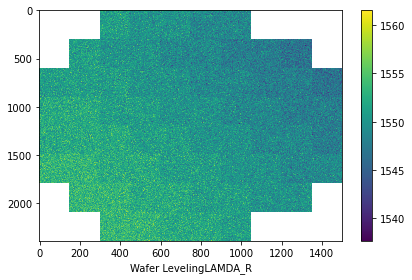

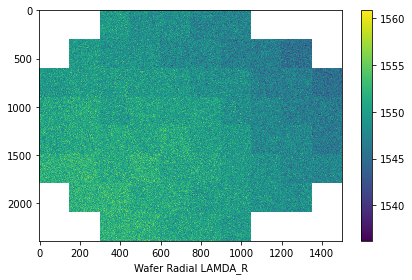

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import os
from os import listdir
from os.path import isfile, join

die_data_path = "/content/interpvfolder/LAMDA_R/Block1by1"

# import glob
# print(glob.glob("/pvfigures/Q/*.png"))
#


search_dir = die_data_path
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files]  # add path to each file
print(files)

files.sort(key=lambda x: os.path.getmtime(x))
dt = pd.read_csv(files[0]).to_numpy()
no_of_row = 8
no_of_columns = 10
die_x_dim = dt.shape[0]
die_y_dim = dt.shape[1]
print(dt.shape[0])
print(dt.shape[1])
wafferarray = np.zeros((dt.shape[0] * no_of_row, dt.shape[1] * no_of_columns))
print(wafferarray.shape)
no_of_dies = 80
die_number = 0
blockrowstartidx = 0
columnstartidx = 0
empty_rows = [0, 1, 6, 7]
leveling_std = 1.46 #nm

empty_columns_for_row = {0: [0, 1, 7, 8, 9],
                         1: [0, 9],
                         6: [0, 9],
                         7: [0, 1, 7, 8, 9]}
parameter = 'LAMDA_R'
row_std_coeff = 3
row_std_dict = {}
i = no_of_row - 1
# j = no_of_columns-1
while i >= 0:
    # for i in range(0, no_of_row):
    blockrowstartidx = i * die_x_dim
    stdlist = []
    if (i != 0 and i % 2 == 0):
        row_std_coeff = row_std_coeff - 0.75
    column_std = row_std_coeff

    # print("blockrowstartidx  :", blockrowstartidx)

    # while j>=0:
    for j in range(0, no_of_columns):
        print("Die :", die_number)
        columnstartidx = j * die_y_dim
        std = column_std * leveling_std
        if (i in empty_rows) and (j in empty_columns_for_row[i]):
            # print("Row Range= " + str(blockrowstartidx) + ' ' + str(blockrowstartidx + die_x_dim))
            # print("Column Range " + str(columnstartidx) + ' ' + str(columnstartidx + die_y_dim))
            wafferarray[blockrowstartidx:(blockrowstartidx + die_x_dim),columnstartidx:(columnstartidx + die_y_dim)] = 0
            die_number += 1
        else:

            # print("Row Range= " + str(blockrowstartidx) + ' ' + str(blockrowstartidx + die_x_dim))
            # print("Column Range " + str(columnstartidx) + ' ' + str(columnstartidx + die_y_dim))
            # print(wafferarray[blockrowstartidx:(blockrowstartidx+die_x_dim),columnstartidx:(columnstartidx+die_y_dim)].shape)
            distribution = pd.read_csv(files[die_number]).to_numpy()
            distribution_mean = distribution.mean()
            # print("Mean" + str(distribution_mean))
            deviation = std
            # if (i >= j):

            # distribution = np.random.normal(distribution_mean, 3*leveling_std,die_x_dim*die_y_dim )
            # distribution = distribution.reshape(die_x_dim,die_y_dim)
            distribution = distribution + deviation
            wafferarray[blockrowstartidx:(blockrowstartidx + die_x_dim),columnstartidx:(columnstartidx + die_y_dim)] = distribution
            # else:
            #     distribution = distribution-deviation
            # distribution = np.random.normal(distribution_mean, -3 * leveling_std, die_x_dim*die_y_dim)
            # distribution = distribution.reshape(die_x_dim, die_y_dim)
            die_number += 1
        if (i % 2 == 0):  # even row change coeffiecient at even rows
            if (j != 0 and j % 2 == 0):
                column_std = column_std - 0.75
        else:
            if (j != 0 and j % 2 == 1):
                column_std = column_std - 0.75
        stdlist.append(column_std)
        # j-=1
    row_std_dict[i] = stdlist
    i -= 1
# print(row_std_dict)
fig, ax = plt.subplots()
wafferarray = np.ma.masked_where(wafferarray == 0, wafferarray)
# np.savetxt("/pvfigures/waffer/" + parameter + ".csv",
          #  wafferarray, delimiter=',')
cmap = matplotlib.cm.viridis
cmap.set_bad(color='white')
im = ax.imshow(wafferarray, cmap=cmap, aspect='auto', interpolation='none')
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)

ax.set_xlabel("Wafer Leveling" + parameter)

fig.colorbar(im, orientation='vertical')
fig.tight_layout()
# fig.savefig("/pvfigures/waffer/" + parameter+'Leveling'+ '.png', dpi=1000)
fig.show()

###############Radial Variations

radial_variation_dict = {7: [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1, -1],
                         6: [-1,    -1, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75,    -1, -1],
                         5: [-1, -0.75, -0.75,  -0.25,  -0.25,  -0.25,  -0.25, -0.75, -0.75, -1],
                         4: [-1, -0.75, -0.75,  -0.25, 0.1, 0.1,  -0.25, -0.75, -0.75, -1],
                         3: [-1, -0.75, -0.75,  -0.25, 0.1, 0.1,  -0.25, -0.75, -0.75, -1],
                         2: [-1, -0.75, -0.75,  -0.25,  -0.25,  -0.25,  -0.25, -0.75, -0.75, -1],
                         1: [-1,    -1, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75,    -1, -1],
                         0: [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1, -1]}
radial_std = 0.9284 #nm
die_number = 0
i = no_of_row - 1
while i >= 0:
    # for i in range(0, no_of_row):
    blockrowstartidx = i * die_x_dim

    for j in range(0, no_of_columns):
        print("Die :", die_number)
        columnstartidx = j * die_y_dim
        # print("Radial Variation ",radial_variation_dict[i][j])
        std = radial_variation_dict[i][j] * leveling_std
        if (i in empty_rows) and (j in empty_columns_for_row[i]):
            # print("Row Range= " + str(blockrowstartidx) + ' ' + str(blockrowstartidx + die_x_dim))
            # print("Column Range " + str(columnstartidx) + ' ' + str(columnstartidx + die_y_dim))
            wafferarray[blockrowstartidx:(blockrowstartidx + die_x_dim),
            columnstartidx:(columnstartidx + die_y_dim)] = 0
            die_number += 1
        else:

            # print("Row Range= " + str(blockrowstartidx) + ' ' + str(blockrowstartidx + die_x_dim))
            # print("Column Range " + str(columnstartidx) + ' ' + str(columnstartidx + die_y_dim))
            # print(wafferarray[blockrowstartidx:(blockrowstartidx+die_x_dim),columnstartidx:(columnstartidx+die_y_dim)].shape)
            distribution = wafferarray[blockrowstartidx:(blockrowstartidx + die_x_dim),columnstartidx:(columnstartidx + die_y_dim)]
            distribution_mean = distribution.mean()
            # print("Mean" + str(distribution_mean))
            deviation = std
            # print("Deviation",deviation)
            # if (i >= j):

            # distribution = np.random.normal(distribution_mean, 3*leveling_std,die_x_dim*die_y_dim )
            # distribution = distribution.reshape(die_x_dim,die_y_dim)
            distribution = distribution + deviation
            wafferarray[blockrowstartidx:(blockrowstartidx + die_x_dim),
            columnstartidx:(columnstartidx + die_y_dim)] = distribution
            die_number+=1
            # else:
            #     distribution = distribution-deviation
            # distribution = np.random.normal(distribution_mean, -3 * leveling_std, die_x_dim*die_y_dim)
            # distribution = distribution.reshape(die_x_dim, die_y_dim)


    i -= 1
fig, ax = plt.subplots()
wafferarray = np.ma.masked_where(wafferarray == 0, wafferarray)
# np.savetxt("pvfigures/waffer/" + parameter + ".csv",
          #  wafferarray, delimiter=',')
cmap = matplotlib.cm.viridis
cmap.set_bad(color='white')
im = ax.imshow(wafferarray, cmap=cmap, aspect='auto', interpolation='none')
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)

ax.set_xlabel("Wafer Radial " + parameter)

fig.colorbar(im, orientation='vertical')
fig.tight_layout()
# fig.savefig("pvfigures/waffer/" + parameter +'Radial'+'.png', dpi=1000)
fig.show()